In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt
from toolz import thread_first, take
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns=100
pd.options.display.max_rows=500

pd.options.display.width = 200

def printer(data, sample=True, n=5, name=None, pprint=False):
    if name:
        print(name, data.shape)
    else:
        print(data.shape)
    print('-'*10)
    
    d = data.sample(min(n, data.shape[0])) if sample else data.head(n)
    if pprint:
        print(d)
    return d

In [2]:
unemploy = pd.read_csv('https://www.bls.gov/web/metro/laucntycur14.txt', 
            skiprows=5, 
            sep='|', 
            header=0, 
            names=['area_code', 'fips_state_code', 'fips_county_code', 'county', 'month_year', 'civilian_labor_force', 'employed', 'unemployed_level', 'unemployed_rate'],
            nrows=45066,
            na_values=['-'],
            dtype={'fips_state_code': str, 'fips_county_code': str})

for col in unemploy:
    if unemploy[col].dtype in ('str', 'object'):
        unemploy[col] = unemploy[col].str.strip()

unemploy[['county', 'state']] = pd.DataFrame(unemploy['county'].str.split(', ').tolist(), columns=['county', 'state'])
unemploy['month_year'] = pd.to_datetime(unemploy['month_year'].str.replace('\(p\)', ''), format='%b-%y')
unemploy['fips'] = unemploy['fips_state_code'] + unemploy['fips_county_code']
printer(unemploy)

(45066, 11)
----------


/usr/local/Caskroom/miniconda/base/envs/titan/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


,area_code,fips_state_code,fips_county_code,county,month_year,civilian_labor_force,employed,unemployed_level,unemployed_rate,state,fips
12708,CN5501100000000,55,011,Buffalo County,2020-08-01,"6,178","5,803",375,6.1,WI,55011
33223,CN2108300000000,21,083,Graves County,2021-03-01,"15,274","14,516",758,5.0,KY,21083
11146,CN2901500000000,29,015,Benton County,2020-08-01,"7,145","6,647",498,7.0,MO,29015
7539,CN2121900000000,21,219,Todd County,2020-07-01,"5,350","5,122",228,4.3,KY,21219
22722,CN0600700000000,06,007,Butte County,2020-12-01,"89,710","82,421","7,289",8.1,CA,06007


In [41]:
covid_counties = pd.read_csv('inputs/us-counties.csv', dtype={'fips': 'str'})
covid_counties['month_year'] = pd.to_datetime(covid_counties['date']).to_numpy().astype('datetime64[M]')
covid_counties = covid_counties.groupby(['fips', 'county', 'month_year'], as_index=False).agg({'cases': 'last', 'deaths': 'last'})
covid_counties['case_diff'] = covid_counties['cases'] - covid_counties.groupby('fips')['cases'].transform('shift').fillna(0)
covid_counties['death_diff'] = covid_counties['deaths'] - covid_counties.groupby('fips')['deaths'].transform('shift').fillna(0)
printer(covid_counties, sample=False, n=20)

(56140, 7)
----------


,fips,county,month_year,cases,deaths,case_diff,death_diff
0,01001,Autauga,2020-03-01,7,0.0,7.0,0.0
1,01001,Autauga,2020-04-01,42,4.0,35.0,4.0
2,01001,Autauga,2020-05-01,221,4.0,179.0,0.0
3,01001,Autauga,2020-06-01,537,12.0,316.0,8.0
4,01001,Autauga,2020-07-01,1015,21.0,478.0,9.0
5,01001,Autauga,2020-08-01,1442,23.0,427.0,2.0
6,01001,Autauga,2020-09-01,1791,27.0,349.0,4.0
7,01001,Autauga,2020-10-01,2159,31.0,368.0,4.0
8,01001,Autauga,2020-11-01,2780,42.0,621.0,11.0
9,01001,Autauga,2020-12-01,4190,48.0,1410.0,6.0


In [42]:
merged = unemploy[['fips', 'month_year', 'county', 'civilian_labor_force', 'employed', 'unemployed_level', 'unemployed_rate', 'state']]\
.merge(covid_counties, how='outer', on=['fips', 'month_year'], indicator=True, suffixes=['_full', ''])
merged

,fips,month_year,county_full,civilian_labor_force,employed,unemployed_level,unemployed_rate,state,county,cases,deaths,case_diff,death_diff,_merge
0,01001,2020-05-01,Autauga County,"25,699","24,064","1,635",6.4,AL,Autauga,221.0,4.0,179.0,0.0,both
1,01003,2020-05-01,Baldwin County,"96,634","89,246","7,388",7.6,AL,Baldwin,290.0,9.0,116.0,6.0,both
2,01005,2020-05-01,Barbour County,"8,618","7,996",622,7.2,AL,Barbour,167.0,1.0,128.0,0.0,both
3,01007,2020-05-01,Bibb County,"8,643","7,872",771,8.9,AL,Bibb,75.0,1.0,33.0,1.0,both
4,01009,2020-05-01,Blount County,"24,314","23,031","1,283",5.3,AL,Blount,62.0,1.0,25.0,1.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56575,78030,2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,St. Thomas,1543.0,16.0,125.0,1.0,right_only
56576,78030,2021-05-01,NaN,NaN,NaN,NaN,NaN,NaN,St. Thomas,1809.0,16.0,266.0,0.0,right_only
56577,78030,2021-06-01,NaN,NaN,NaN,NaN,NaN,NaN,St. Thomas,2138.0,19.0,329.0,3.0,right_only
56578,78030,2021-07-01,NaN,NaN,NaN,NaN,NaN,NaN,St. Thomas,2530.0,22.0,392.0,3.0,right_only


<AxesSubplot:title={'center':'Somerset, NJ'}, xlabel='month_year'>

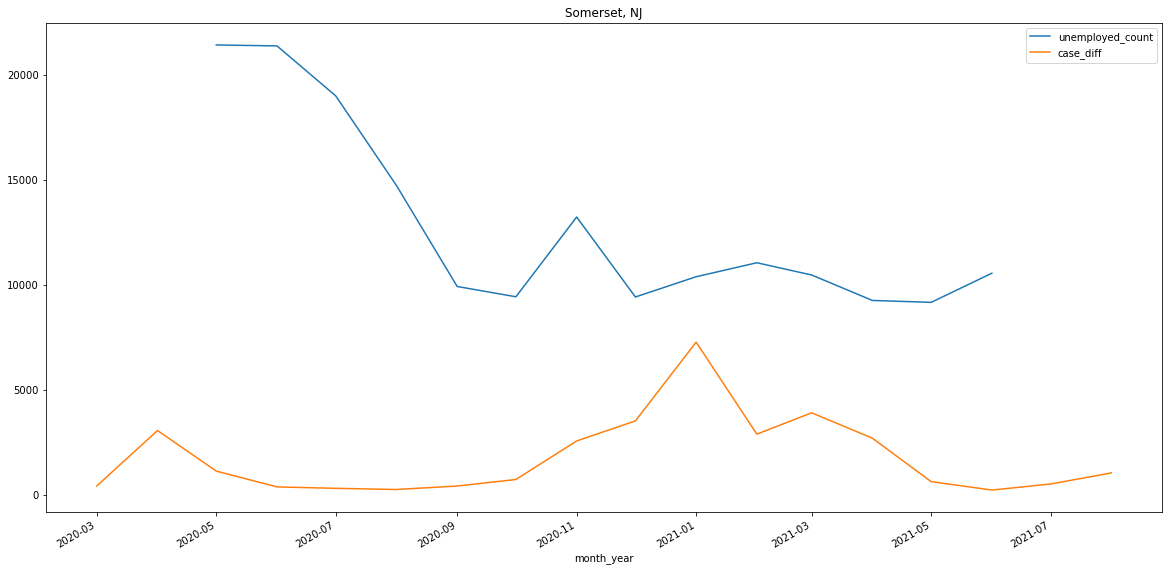

In [82]:
rand = np.random.choice(merged.fips.unique())
name = merged.loc[merged.fips == rand].county.iloc[0] + ', ' + merged.loc[merged.fips == rand].state.iloc[0]
merged.loc[(merged.fips == rand)]\
.assign(unemployed_count = lambda x: pd.to_numeric(x.unemployed_level.str.replace(',', '')))\
.plot(x='month_year', y=['unemployed_count', 'case_diff'], kind='line', figsize=(20, 10), title=name)

In [83]:
rename = {
    'Binge drinking among adults aged >=18 years': 'binge_drinking_pct',
    'Current lack of health insurance among adults aged 18-64 years': 'lack_health_insurance_pct', 
    'Mental health not good for >=14 days among adults aged >=18 years': 'poor_mental_health_pct', 
    'No leisure-time physical activity among adults aged >=18 years': 'no_leisure_time_pct', 
    'Sleeping less than 7 hours among adults aged >=18 years': 'bad_sleep_pct'
}

outcomes = pd.read_csv('inputs/places-local-outcomes.csv')
outcomes = outcomes.loc[outcomes.LocationName.notnull()]
keep = ['Mental Health', 'Sleep <7 hours', 'Physical Inactivity', 'Health Insurance', 'Binge Drinking']
outcomes = outcomes.loc[outcomes.Short_Question_Text.isin(keep) & (outcomes.Year == 2018)]\
.rename(columns={'StateAbbr': 'state', 'LocationName': 'county', 'Measure': 'measure_name', 'Data_Value': 'value'})\
.pivot_table(index=['state', 'county'], columns=['measure_name'], values='value')\
.reset_index()\
.rename(columns=rename)
outcomes['county'] = np.where(outcomes['state'] == 'LA', outcomes['county'] + ' Parish', outcomes['county'])
outcomes['county'] = np.where(outcomes['state'] == 'VA', outcomes['county'] + ' City', outcomes['county'])
outcomes['county'] = outcomes['county'].str.replace(' city City', ' City').str.replace('City City', 'City')
outcomes['county'] = np.where(outcomes['state'] == 'AK', outcomes['county'].apply(lambda x: x.split(' ')[0]), outcomes['county'])
printer(outcomes)

(3142, 7)
----------


measure_name,state,county,binge_drinking_pct,lack_health_insurance_pct,poor_mental_health_pct,no_leisure_time_pct,bad_sleep_pct
2491,TN,Moore,14.60,15.20,16.60,31.35,40.45
2837,VA,Cumberland City,14.90,17.90,15.20,29.45,40.05
2480,TN,Loudon,14.55,15.35,15.25,29.10,40.55
1718,NC,New Hanover,17.35,15.30,13.55,21.70,33.90
2703,TX,Orange,18.30,22.40,15.10,28.55,38.15


In [84]:
care_about = {'FIPS Code': 'fips', 
                                  'County Name': 'county', 
                                  'Estimated hesitant': 'estimated_hesitant', 
                                  'Estimated hesitant or unsure': 'estimated_hesitant_unsure',
                                  'Social Vulnerability Index (SVI)': 'social_vulnerability_index',
                                 'SVI Category': 'svi_category',
                                 'CVAC level of concern for vaccination rollout': 'cvac_level_of_concern', 
                                 'Percent adults fully vaccinated against COVID-19 (as of 6/10/21)': 'percent_adults_vaccinated_by_jun_2021',
                                 'State Code': 'state'}
vaccine = pd.read_csv('inputs/vaccine-hesitation.csv', dtype={'FIPS Code': 'str'}, usecols=care_about.keys())
vaccine = vaccine.rename(columns=care_about)
vaccine['fips'] = vaccine['fips'].str.zfill(5)
vaccine[['county', 'state_full_name']] = pd.DataFrame(vaccine['county'].str.split(', ').tolist(), columns=['county', 'state_full_name'])
vaccine['county'] = vaccine['county'].str.replace(' County', '').str.replace(' city', ' City')
vaccine['county'] = np.where(vaccine['state'] == 'VA', vaccine['county'] + ' City', vaccine['county'])
vaccine['county'] = vaccine['county'].str.replace(' city City', ' City').str.replace('City City', 'City')
vaccine['county'] = np.where(vaccine['state'] == 'AK', vaccine['county'].apply(lambda x: x.split(' ')[0]), vaccine['county'])
vaccine['county'] = np.where(vaccine['fips'] == '35013', 'Doña Ana', vaccine['county'])
vaccine.loc[(vaccine.state == 'VA')].head()

,fips,county,estimated_hesitant,estimated_hesitant_unsure,social_vulnerability_index,svi_category,cvac_level_of_concern,percent_adults_vaccinated_by_jun_2021,state,state_full_name
206,51101,King William City,0.0581,0.1140,0.04,Very Low Vulnerability,0.06,0.321,VA,Virginia
207,51103,Lancaster City,0.0613,0.1235,0.16,Very Low Vulnerability,0.11,0.356,VA,Virginia
208,51093,Isle of Wight City,0.0638,0.1301,0.34,Low Vulnerability,0.14,0.154,VA,Virginia
209,51111,Lunenburg City,0.0714,0.1474,0.86,Very High Vulnerability,0.50,0.335,VA,Virginia
210,51109,Louisa City,0.0611,0.1213,0.33,Low Vulnerability,0.21,0.031,VA,Virginia


In [211]:
updated = vaccine.merge(outcomes, how='outer', on=['state', 'county'])\
.drop(['county', 'state'], axis=1)\
.merge(merged, how='outer', on='fips')\
.query("_merge == 'both'")\
.drop('_merge', axis=1)

printer(updated)

(44764, 25)
----------


,fips,estimated_hesitant,estimated_hesitant_unsure,social_vulnerability_index,svi_category,cvac_level_of_concern,percent_adults_vaccinated_by_jun_2021,state_full_name,binge_drinking_pct,lack_health_insurance_pct,poor_mental_health_pct,no_leisure_time_pct,bad_sleep_pct,month_year,county_full,civilian_labor_force,employed,unemployed_level,unemployed_rate,state,county,cases,deaths,case_diff,death_diff
41298,39133,0.1343,0.1879,0.25,Low Vulnerability,0.14,0.491,Ohio,17.70,8.80,15.15,24.0,39.40,2021-06-01,Portage County,"82,656","77,854","4,802",5.8,OH,Portage,13269.0,216.0,110.0,5.0
33901,34029,0.0548,0.1158,0.34,Low Vulnerability,0.16,0.532,New Jersey,16.50,12.60,13.70,27.6,37.20,2020-07-01,Ocean County,"287,621","251,685","35,936",12.5,NJ,Ocean,10482.0,1014.0,800.0,59.0
40602,40015,0.1975,0.2604,0.95,Very High Vulnerability,0.88,0.539,Oklahoma,13.65,20.00,16.90,32.4,38.75,2020-05-01,Caddo County,"12,060","11,018","1,042",8.6,OK,Caddo,160.0,10.0,98.0,3.0
33681,31083,0.0893,0.1350,0.12,Very Low Vulnerability,0.07,0.380,Nebraska,20.20,12.15,11.45,26.2,30.05,2020-08-01,Harlan County,"1,707","1,666",41,2.4,NE,Harlan,6.0,0.0,5.0,0.0
6654,01047,0.1808,0.2526,0.95,Very High Vulnerability,0.78,0.313,Alabama,10.90,19.70,18.55,40.3,43.35,2020-06-01,Dallas County,"14,905","12,879","2,026",13.6,AL,Dallas,814.0,8.0,542.0,5.0


In [220]:
agg = {
    'estimated_hesitant': 'mean',
    'estimated_hesitant_unsure': 'mean',
    'social_vulnerability_index': 'mean',
    'svi_category': 'first',
    'cvac_level_of_concern': 'mean',
    'percent_adults_vaccinated_by_jun_2021': 'mean',
    'binge_drinking_pct': 'mean',
    'lack_health_insurance_pct': 'mean',
    'poor_mental_health_pct': 'mean',
    'no_leisure_time_pct': 'mean', 
    'bad_sleep_pct': 'mean',
    'unemployed_rate': 'mean',
    'case_diff': 'mean',
    'death_diff': 'mean',
}
updated['svi_category'] = updated['svi_category'].copy().replace({'High Vulnerability': '2-High Vulnerability',
                                                      'Very High Vulnerability': '1-Very High Vulnerability',
                                                      'Moderate Vulnerability': '3-Moderate Vulnerability',
                                                     'Low Vulnerability': '4-Low Vulnerability',
                                                     'Very Low Vulnerability': '5-Very Low Vulnerability'})
updated['svi_simple'] = updated['svi_category'].copy().replace({'High Vulnerability': '1-High',
                                                      'Very High Vulnerability': '1-High',
                                                      'Moderate Vulnerability': '2-Medium',
                                                     'Low Vulnerability': '3-Low',
                                                     'Very Low Vulnerability': '3-Low'})
group_by = 'svi_category'
overall_month = updated.groupby([group_by, 'month_year'], as_index=False).agg(agg)
overall_county = updated.groupby([group_by, 'county'], as_index=False).agg(agg)
overall_state= updated.groupby([group_by, 'state'], as_index=False).agg(agg)

KeyError: 'svi_simple'

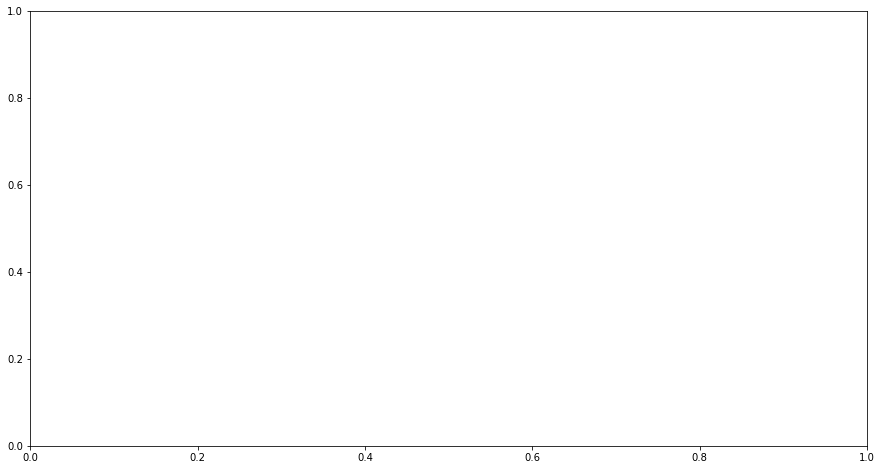

In [221]:
fig, ax = plt.subplots(1, figsize=(15, 8))
pal = sns.color_palette("rocket_r", as_cmap=True)
# sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
# sns.color_palette("coolwarm", as_cmap=True)
# sns.color_palette("crest", as_cmap=True)
sns.scatterplot(data=overall_county.query("case_diff < 50000").sort_values('svi_simple'), x='svi_simple', y='case_diff', hue='lack_health_insurance_pct', size='case_diff', 
                hue_norm=(0, updated['unemployed_rate'].max()), ax=ax, palette=pal)

<AxesSubplot:xlabel='month_year', ylabel='death_diff'>

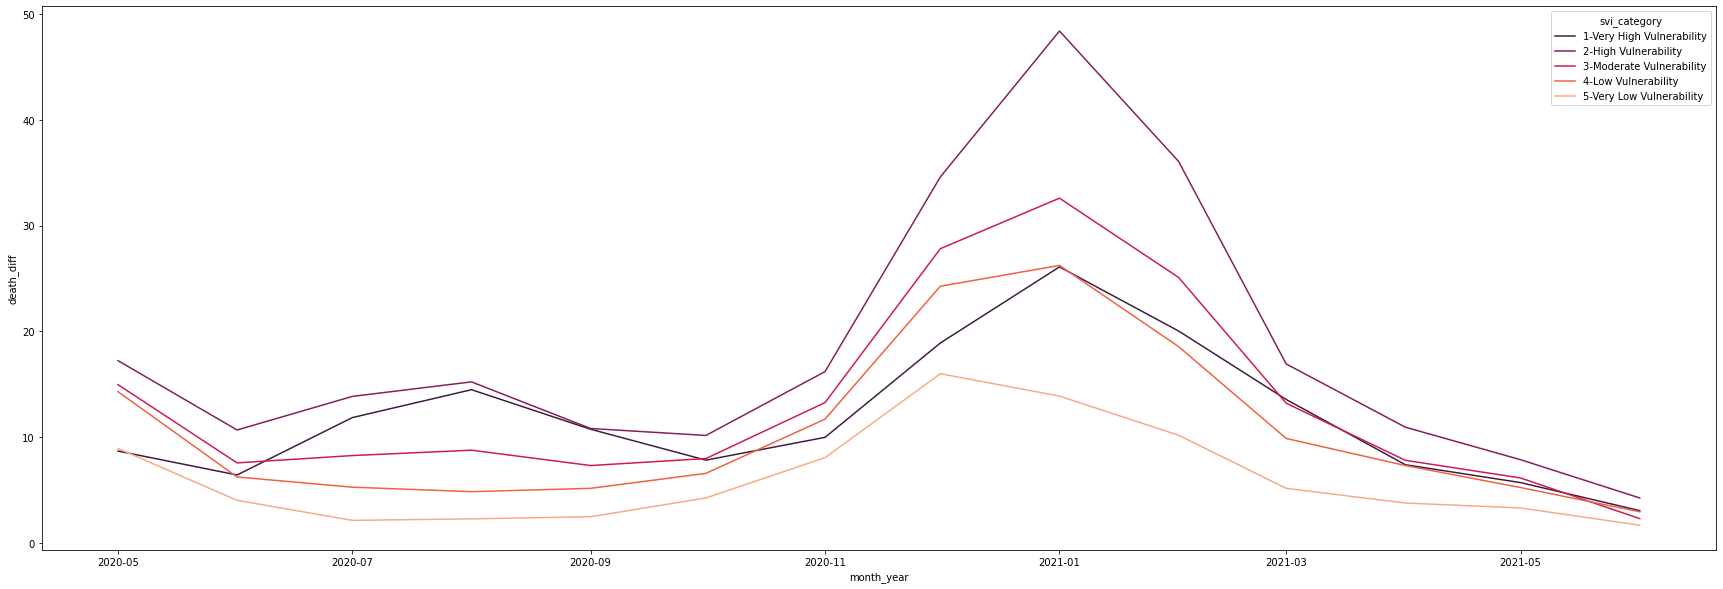

In [224]:
fig, ax = plt.subplots(1, figsize=(30, 10))
sns.lineplot(data=overall_month, x='month_year', y='death_diff', hue='svi_category', palette="rocket", sort=True, ax=ax)

<AxesSubplot:xlabel='month_year', ylabel='case_diff'>

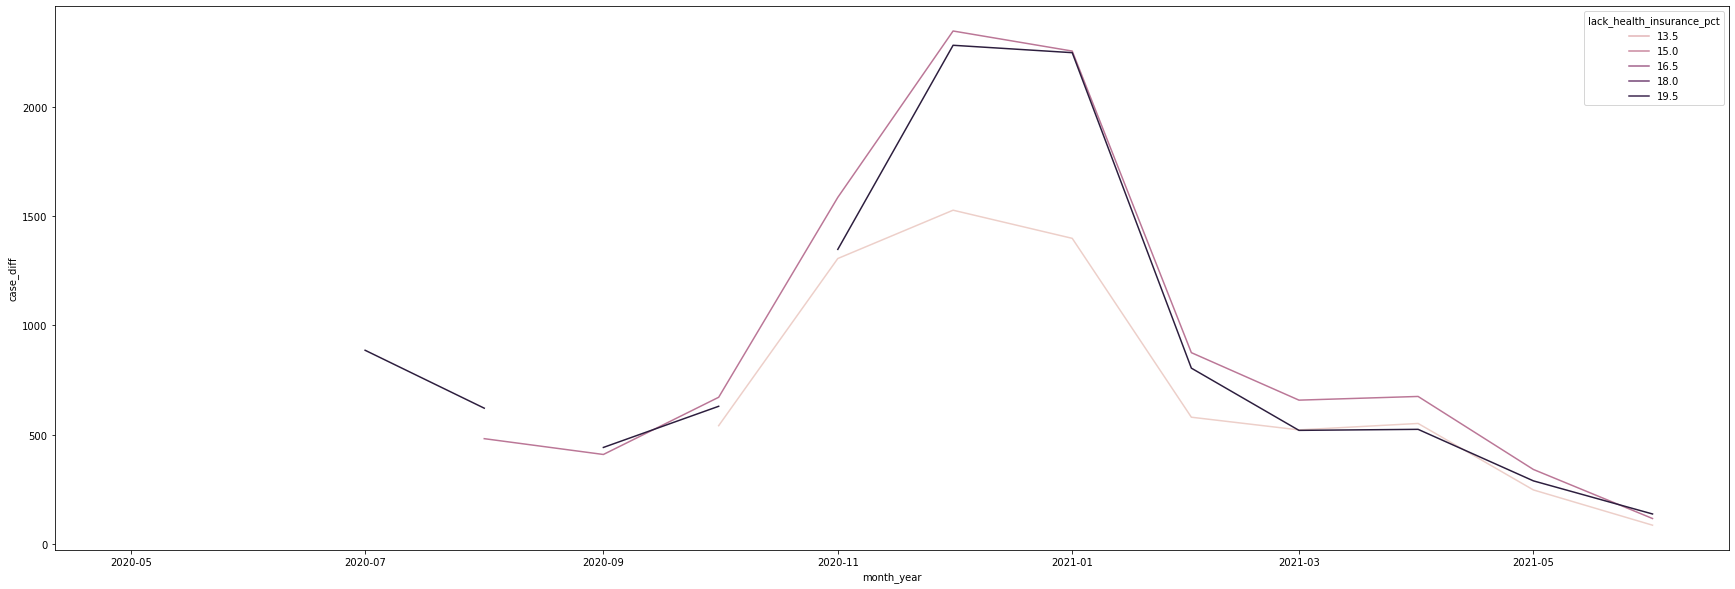

In [200]:
fig, ax = plt.subplots(1, figsize=(30, 10))
sns.lineplot(data=overall_month.assign(unemployed_rate = lambda x: x['unemployed_rate'].fillna(0) / 100), 
             x='month_year', y='case_diff', hue='lack_health_insurance_pct', sort=True, ax=ax)

In [70]:
area = pd.read_csv('https://download.bls.gov/pub/time.series/la/la.area', sep='\t', usecols=['area_type_code', 'area_code', 'area_text'])
printer(area)

(8321, 3)
----------


,area_type_code,area_code,area_text
432,B,MT5529100000000,"La Crosse-Onalaska, WI-MN Metropolitan Statist..."
5842,G,CT3774440000000,"Wilmington city, NC"
6148,G,CT4872176000000,"Temple city, TX"
7082,H,CS2539765000000,"Medfield town, MA"
7693,H,CS5083050000000,"West Windsor town, VT"


In [57]:
40*12*3219

1545120